# EDSA 2022 Classification Hackathon

### South African Language Identification

© Explore Data Science Academy (Accelerator)

# By ``Michael Omosebi``

# Introduction

South Africa is a multicultural society that is characterised by its rich linguistic diversity, with eleven(11) official languages. Most South Africans are multilingual and able to speak at least two or more of the official languages.

As systems and devices in South-Africa communicate in these multi-languages, in this challenge, we will take text which is in any of South Africa's 11 Official languages and identify which language the text is in.

## Outline
This challenge is structured as follows:

- Expolatory Data Analysis
- Data Cleaning/Engineering
- Multi-class Classification with building some models
- Hyperparameter tuning and classification with the best model

In [37]:
# import comet_to begin an experiment
from comet_ml import Experiment

# Creating an experiment with comet ☄ api key
experiment = Experiment(
    api_key="xftBfqGXxdHiGUbbfhpQGbAmN",
    project_name="sa-lang-classification",
    workspace="michaelomosebi",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn, xgboost. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in 'C:\\Users\\Engr  Dasilva\\Videos\\EXPLORE\\EDSA\\Advanced Classification\\Predict Hackaton\\south-african-language-identification' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/michaelomosebi/sa-lang-classification/9e8fb032e6da4eb49238a6cf933f774c



### Imports

In [2]:
#Importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize, TreebankWordTokenizer
import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

C:\Users\Engr  Dasilva\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Loading Datasets

In [6]:
#Loading the csv files to dataframe
train_df = pd.read_csv('train_set.csv')
test_df = pd.read_csv('test_set.csv')

#Viewing a slice of the datframe
print("First 5 rows of the train data")
display(train_df.tail())

print('First 5 rows of the test data')
display(test_df.tail())

First 5 rows of the train data


,lang_id,text
32995,tsn,popo ya dipolateforomo tse ke go tlisa boetele...
32996,sot,modise mosadi na o ntse o sa utlwe hore thaban...
32997,eng,closing date for the submission of completed t...
32998,xho,nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999,sot,mafapha a mang le ona a lokela ho etsa ditlale...


First 5 rows of the test data


,index,text
5677,5678,You mark your ballot in private.
5678,5679,Ge o ka kgetha ka bowena go se šomiše Mofani k...
5679,5680,"E Ka kopo etsa kgetho ya hao ka hloko, hobane ..."
5680,5681,"TB ke bokudi ba PMB, mme Morero o tla lefella ..."
5681,5682,Vakatjhela iwebhusayidi yethu ku-www.


* The test data set is observed to have one extra column named 'index'

### Data Exploration

In [136]:
#Info on train dataset
print(train_df.info(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB
None 



* Nice! No null values.

In [137]:
#Description on train dataset
print(train_df.describe().T, "\n")

         count unique                                                top  freq
lang_id  33000     11                                                xho  3000
text     33000  29948  ngokwesekhtjheni yomthetho ophathelene nalokhu...    17 



* There are eleven unique language IDs as expected.
* Some texts seem to have been repeated, as we have 29948 unique texts. This must have been during an operaion to balance the dataset provided.

In [3]:
#Looking into the 
count = train_df.groupby("lang_id").count()["text"].reset_index().sort_values(by="lang_id", ascending=True)
display(count.style.background_gradient(cmap="Blues"))

,lang_id,text
0,afr,3000
1,eng,3000
2,nbl,3000
3,nso,3000
4,sot,3000
5,ssw,3000
6,tsn,3000
7,tso,3000
8,ven,3000
9,xho,3000


* Looks close to a perfectly balanced data to train with ! - All class have equal number of observations

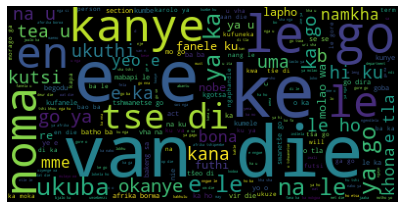

In [136]:
#Display the most recurrent words across all observations in a wordcloud image
full_text = " ".join(train_df['text'])

wc = WordCloud(background_color='black')
img = wc.generate(full_text)
plt.figure(figsize=(7,7))
plt.imshow(img)
plt.axis('off')
plt.show()

* A lot of repeating single letter and double letter words. This insight will be applied during cleaning to remove words with less that 3 characters

In [131]:
#Check out a slice in the text lenght for each observation to determine what cleaning needs to be done.
for text in test_df['text'][2000:2010]:
    print(text)

mabalane wa khothe ya ndinganyiso' zwi amba mabalane wa khothe ya ndinganyiso o tholiwaho kana o nangiwaho u ya nga khethekanyo 17, yo vhalwaho na khethekanyo 31, yo katela na zwi.
Khethululo zwi songo tea kha u. etshedza dzimbuelo, dzitshomedzo dzine dza tshimbilelana na ndindakhombo.
Komiti ya Tshepetšo: E thuša BOT mo go netefatšeng tshepetšo e botse ya setlamo, bjale ka go kgoboketša ditefelo, ditefelo tša dikgopelo le tlhokomelo ya direkhoto tša leloko. Komiti gape e thuša BOT ka thekišo le kwalakwatšo.
Indlu yowiso-mthetho yephondo ingaphumeza umgaqo-siseko wephondo okanye, apho kufunekayo, ingawutshintsha umgaqo-siseko wayo, ukuba, ubuncinane, isibini kwisithathu samalungu ayo avotela ukuwuvuma uMthetho oYilwayo wokwenjenjalo.
Ngano dza tsiko.
<fn>GOV-ZA.WQFlyer_afr.2010-03-25.af.txt</fn>
Mfuwo, vukhongeri na tindzimi: Vaaki va nga tiphina hi mfuwo wa vona, va landzelela vukhongeri bya vona no tirhisa ririmi ra vona.
Ukubonelela kunye nokukhusela ulimo kwiifama.
Bakeng sa ho tsw

##### Although the data looked clean enough at first glance, the following observations were made:

- The text still contains numbers and special characters as seen above.
- Some lines contain two or more languages. This will likely ```inhibit a 100% prediction accuracy```.
- The local languages have compound words whose meaning may be affected by punctutaions cleaning.
- Train data set is perfectly balanced

## Data Preprocessing

- The two datasets will be combined and preprocessed as one.
- ...then, split after vectorizaion of selected best feautures; leading to training and validation

In [4]:
#Creating a worked dataframe from the train data that can be concatenated with the train data
#By dropping the extra column in the test dataset
test_df1 = test_df.drop('index', axis=1, inplace=False)

#Concatenate both datasets to one for once-through processing/cleaning
df = pd.concat([train_df, test_df1])
df.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [5]:
#Creating a function to remove numbers and punctuations

punc_numbers = string.punctuation + '0123456789'

def remove_punctuation(post):
  """This function returns a string item that has no punctuation marks and numbers."""
  punc_numbers = string.punctuation + '0123456789'
  return ''.join([l for l in post if l not in punc_numbers])

In [7]:
#removing punctuation
df['text'] = df['text'].apply(remove_punctuation)

In [8]:
#tokenizing
tokenizer = TreebankWordTokenizer()

#tokenizing train data
df['text'] = train_df['text'].apply(tokenizer.tokenize)

In [9]:
#removing stop words
eng_stop = stopwords.words('english')

#removing stop words in data
df['text'] = df['text'].apply(lambda x: ' '.join([item for item in x if item not in eng_stop]))

In [163]:
#Taking a look at the data
df.tail()

,lang_id,text
5677,NaN,umthethosisekelo ugunyaza itjhuguluko ebujamen...
5678,NaN,dikhampani kapa kgwebo tsa motho ya mong di lo...
5679,NaN,dingaka di dumela hore motho ya tsubang dithet...
5680,NaN,tumelo yeo e fiwago ka ntle ga afrika borwa e ...
5681,NaN,bouto e tee go dihektara tše dingwe le tše din...


In [10]:
#Vectorizing
vector = TfidfVectorizer(min_df=5)

#Vectorizing train data
vector.fit(train_df['text'])

TfidfVectorizer(min_df=5)

In [11]:
train_tfidf = vector.transform(train_df['text'])
test_tfidf = vector.transform(test_df['text'])

In [12]:
display(train_tfidf.shape)
display(test_tfidf.shape)

(33000, 24460)

(5682, 24460)

In [13]:
#Transform vectorized train data to a dataframe
vectorized_train_df = pd.DataFrame(train_tfidf.todense(), columns=vector.get_feature_names_out())

#Transform vectorized test data to a dataframe
vectorized_test_df = pd.DataFrame(test_tfidf.todense(), columns=vector.get_feature_names_out())

In [168]:
vectorized_train_df.head()

,aa,aan,aanbeveel,aanbevelings,aanbied,aandag,aandeel,aandui,aanduiding,aangaande,...,ṱhuṱhuwedzo,ṱo,ṱola,ṱoḓa,ṱoḓea,ṱoḓou,ṱun,ṱuwa,ṱuṱuwedza,ṱuṱuwedzwa
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#Training dataset
train_feat = vectorized_train_df[:len(train_df)]
train_target = train_df['lang_id']

#Test dataset
test_features =  vectorized_test_df[:len(test_df):]

In [15]:
X_train, X_test, y_train, y_test =train_test_split(train_feat, 
                                                   train_target, 
                                                   test_size=0.2, 
                                                   random_state=50)

In [16]:
# Set up selector, choosing score function and number of features to retain
selector = SelectKBest(score_func=f_classif, k=21000)

# Transform (i.e.: run selection on) the training data
fit = selector.fit(X_train, y_train)

#Selecting the Best k features from the train dataset
X_train_kbest = X_train[X_train.columns[selector.get_support(indices=True)]]
X_test_kbest = X_test[X_test.columns[selector.get_support(indices=True)]]

In [17]:
#Select same columns for test dataset as above
select_columns = X_test_kbest.columns
cols = list(select_columns)

#Selecting the Best k features from the test dataset
test_features_kbest = test_features[cols]

## Modelling

Three models will be separately tried out and the best will be picked based in f1 score on the train and test predictions.

- Logistic Regression
- Gaussian Naive Bayes
- Multinomial Naive Bayes

In [18]:
#Train a Logistic regression model 
logreg = LogisticRegression(random_state=50)

#Fitting
logreg.fit(X_train_kbest, y_train)

#Validate
y_pred_test = logreg.predict(X_test_kbest)

C:\Users\Engr  Dasilva\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
# Generate predictions from test data using Logistic regression model
y_pred_LR = logreg.predict(test_features_kbest)

#f1 score on train
f1_score_LR = metrics.f1_score(y_test, y_pred_test, average='macro')
f1_score_LR

0.9955900456772018

In [24]:
#Train a Gaussian Naive Bayes model 
GNB = GaussianNB()

#Fitting
GNB.fit(X_train_kbest, y_train)

#Validate
y_pred_test_GNB = GNB.predict(X_test_kbest)

In [25]:
# Generate predictions from test data using Gaussian Naive Bayes model
y_pred_test_GNB1 = GNB.predict(test_features_kbest)

#f1 score on train
f1_score_GNB = metrics.f1_score(y_test, y_pred_test_GNB, average='macro')
f1_score_GNB

0.9957338255089159

In [35]:
#Train a Multinomial Naive Bayes model 
model = MultinomialNB(alpha=0.2)

#Fitting
model.fit(X_train_kbest, y_train)
run_time = %timeit -q -o model.fit(X_train_kbest, y_train)

#Validate
y_pred_MNB = model.predict(X_test_kbest)

print("Multinomial NB Classifier Training time:", run_time )

Multinomial NB Classifier Training time: 3.34 s ± 189 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
# Generate predictions from test data using Gaussian Naive Bayes model
y_pred_MNB1 = model.predict(test_features_kbest)

#f1 score on train
f1_score = metrics.f1_score(y_test, y_pred_MNB, average='macro')
display(f1_score)
#Accuracy
accuracy  = metrics.accuracy_score(y_test, y_pred_MNB)
display(accuracy)

0.9986328472875805

0.9986363636363637

In [33]:
#Creating a submission

submission_df = pd.DataFrame({"index": test_df['index'],
    "lang_id": y_pred_MNB1})
submission_df.to_csv('submissionMNBfinal.csv', index=False)

In [34]:
sub_temp = pd.read_csv('submissionMNBFinal.csv')
sub_temp.head()

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr


### Model Selection & Explanation

The Multinomial Naive Bayes will be selected for the purpose of this exercise, based on the models that have been tried for the following reasons:

- Prediction on the train dataset and the unseen data gave a better f1 score.
- Run time was lower, which indicates a lower computing requirement and speed of processing.
- Being a probability algorithm, it is simple to implement and pretty straight-forward.
- 

The Multinomial Naive Bayes algorithm is a Bayesian learning approach in which a program guesses the tag of a text using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

The Naive Bayes classifier is made up of a number of algorithms that all have one thing in common: each feature being classed is unrelated to any other feature. A feature's existence or absence has no bearing on the inclusion or exclusion of another feature.

### Hyperparameter Tuning on Multinomial Naive Bayes

In [121]:
#Hyperparameter tuning using GridSearchCV
search_space = {"alpha": [0.2, 0.5, 1.0],
                "fit_prior": [True, False]
               }

In [123]:
GS = GridSearchCV(estimator = model,
                 param_grid = search_space,
                 scoring = "f1",
                 cv = 5,
                 verbose = 4)

In [7]:
GS.fit(X_train_kbest, y_train)

In [127]:
GS.best_params_

{'alpha': 0.2, 'fit_prior': True}

### Versioning Experiments on Comet

In [41]:
#Logging results to comet --- Create a dictionary for the data to be logged

params = {"random_state": 50,
         "model_type": "Multinomial NB",
         "scaler": "None"
         }

metrics = {"Accuracy": accuracy,
          "f1": f1_score,
          }

In [42]:
#Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

In [43]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/michaelomosebi/sa-lang-classification/9e8fb032e6da4eb49238a6cf933f774c
COMET INFO:   Metrics:
COMET INFO:     Accuracy : 0.9986363636363637
COMET INFO:     f1       : 0.9986328472875805
COMET INFO:   Parameters:
COMET INFO:     model_type   : Multinomial NB
COMET INFO:     random_state : 50
COMET INFO:     scaler       : None
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: --